In [113]:
# considera solo le probabilità superiori a:
min_prob = 0.1

# ----------------------------------------------------------------------- #
# seleziona un'immagine e la dimensione con la quale la vuoi caricare     #
# ----------------------------------------------------------------------- #



fname = '/notebooks/images/test_fcn/used/a_17_1.png'
ll = 17 # true
ll = 12
IMAGE_SIZE_NEW = (300, 500)

fname = '/notebooks/images/test_fcn/used/02_01.ppm'
ll = 2 # true
ll = 17
IMAGE_SIZE_NEW = (59, 58)

# prova MAX: vince il 12 con attivazioni ovunque tranne sul cartello
# prova heatmap: ottima copertura
fname = '/notebooks/images/test_fcn/used/17_01.ppm'
ll = 17 # true
#ll = 12
IMAGE_SIZE_NEW = (62, 61)

# prova MAX: 
# prova heatmap: 
fname = '/notebooks/images/test_fcn/used/25_01.ppm'
ll = 25 # true
#ll = 12
IMAGE_SIZE_NEW = (112, 121) # real
IMAGE_SIZE_NEW = (60, 60)

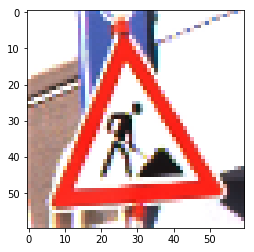

In [114]:
import sys
import scipy
import skimage
from skimage import io
from skimage import transform
from skimage.filters import gaussian

import tensorflow as tf
from keras.layers import Dense, Dropout, Flatten, merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

import my_mod_load as load
import my_mod_manipulate_image as manipulate
import numpy as np
import settings


from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.engine import InputLayer
import keras

import matplotlib.pyplot as plt


# load e normalizzazioen dell'immagine
img = io.imread(fname)
img = transform.resize(img, IMAGE_SIZE_NEW, order=3)
img_original = img

img = gaussian(img,.6,multichannel=True)*255
img = manipulate.normalize_img(img.astype(np.uint8))
img.shape = (1,) + img.shape

# print dell'immagine originale
plt.imshow(np.array(img_original.squeeze()))

In [115]:
model = '/scripts/models/2018-04-14_1245/model_108-108-100_ep20'

json_file = open("{}.json".format(model), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("{}.h5".format(model))

#loaded_model.summary()

In [116]:
new_model = Sequential()
input_layer = InputLayer(input_shape=(None, None, 1), name="input_new")
new_model.add(input_layer)

new_model.add(loaded_model.get_layer("conv2d_1"))
new_model.add(loaded_model.get_layer("conv2d_2"))
new_model.add(loaded_model.get_layer("max_pooling2d_1"))
#new_model.add(loaded_model.get_layer("dropout_1"))
new_model.add(loaded_model.get_layer("conv2d_3"))
new_model.add(loaded_model.get_layer("conv2d_4"))
new_model.add(loaded_model.get_layer("max_pooling2d_2"))
#new_model.add(loaded_model.get_layer("dropout_2"))

# first dense layer
flatten_layer = loaded_model.get_layer("flatten_1")
flatten_dim = flatten_layer.input_shape
print(flatten_dim)

dense_layer = loaded_model.get_layer("dense_1")
input_shape_dense = dense_layer.input_shape
print(input_shape_dense)
output_dim_dense =  dense_layer.get_weights()[1].shape[0]
print(output_dim_dense)
W, b = dense_layer.get_weights()
shape = (flatten_dim[1], flatten_dim[2], flatten_dim[3], output_dim_dense)
print(shape)
new_W = W.reshape(shape)
print("dimensioni nuovo kernel: ")
print(flatten_dim[1])
print(flatten_dim[2])
new_layer = Convolution2D(output_dim_dense,
                         (flatten_dim[1], flatten_dim[2]),
                         strides=(1, 1),
                         activation=dense_layer.activation,
                         padding='valid',
                         weights=[new_W, b],
                         name="conv2d_x1")
new_model.add(new_layer)

#new_model.add(loaded_model.get_layer("dropout_3"))

# second dense layer
dense_layer = loaded_model.get_layer("dense_2")
input_shape_dense = dense_layer.input_shape
print(input_shape_dense)
output_dim_dense =  dense_layer.get_weights()[1].shape[0]
print(output_dim_dense)
W, b = dense_layer.get_weights()
shape = (1, 1, input_shape_dense[1], output_dim_dense)
new_W = W.reshape(shape)
new_layer = Convolution2D(output_dim_dense,
                          (1, 1),
                          strides=(1, 1),
                          activation=dense_layer.activation,
                          padding='valid',
                          weights=[new_W, b],
                          name="conv2d_x2")
new_model.add(new_layer)

#print(new_model.summary())

(None, 8, 8, 108)
(None, 6912)
100
(8, 8, 108, 100)
dimensioni nuovo kernel: 
8
8
(None, 100)
43


In [117]:
predicted_proba = new_model.predict(img)
print("dimensione dell'otuput")
print(predicted_proba.shape)

dimensione dell'otuput
(1, 8, 8, 43)


In [118]:
import operator

#print("dimensione immagine originale x,y e dimensione output x,y")

#print(IMAGE_SIZE_NEW[0])
#print(IMAGE_SIZE_NEW[1])
#num_1 = predicted_proba.shape[1]
#num_2 = predicted_proba.shape[2]
#print(num_1)
#print(num_2)


sums = {}
my_max = 0
my_sum = 0
my_class = -1
for i in range(0, 43):
#    print(i)
    matrix = predicted_proba[:,:,:,i]
    my_sum = matrix.sum()
    sums[i] = my_sum
    #print("{}: {}".format(i, my_sum))
    if my_sum >= my_max:
        my_max = my_sum
        my_class = i       

sorted_x = sorted(sums.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_x)
print("risutato:")
print(my_max)
print(my_class)
print("right class:")
print(predicted_proba[:,:,:,ll].sum())


[(13, 12.337814), (22, 8.0260639), (18, 6.507678), (32, 5.2184258), (12, 4.362216), (39, 3.0702777), (15, 2.5635281), (26, 2.5275481), (25, 2.4731553), (38, 2.3913689), (29, 1.5781239), (24, 1.5209455), (27, 1.4036269), (20, 1.0914422), (28, 1.0369203), (41, 0.9426648), (6, 0.70734894), (11, 0.61632812), (33, 0.59072912), (30, 0.54223549), (35, 0.51915151), (34, 0.46798342), (42, 0.46363765), (40, 0.35290992), (36, 0.33978397), (37, 0.31608903), (4, 0.31477964), (19, 0.29507285), (14, 0.22466096), (16, 0.18422681), (0, 0.13465875), (21, 0.12333088), (17, 0.11977062), (10, 0.11572215), (7, 0.11359444), (31, 0.10844526), (23, 0.095086634), (9, 0.077759095), (1, 0.053671163), (3, 0.03033819), (8, 0.020503517), (5, 0.013122275), (2, 0.0072599407)]
risutato:
12.3378
13
right class:
2.47316


In [119]:
#ll = my_class
#ll=17

dimensione immagine originale x,y e dimensione output x,y
60
60
8
8
[[  0.    0.    0.    0.2   0.8   0.2   0.    0. ]
 [  0.    0.    0.1   0.4   1.4   2.4   0.    0. ]
 [  0.    0.    0.    0.2   0.8   1.6   0.    0. ]
 [  0.    0.1   0.    0.1   0.9   1.4   3.9   0.1]
 [  0.    0.    0.1   2.6   7.3  10.3   3.1   0. ]
 [  0.    0.    0.3  54.3  95.4   1.1   0.1   1.2]
 [  0.    0.    0.2  39.8   3.5   0.1   0.1   1.2]
 [  0.    0.1   1.6  10.    0.2   0.    0.    0.3]]


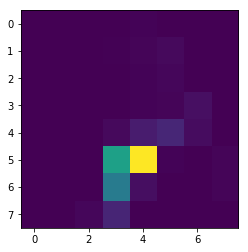

In [120]:
print("dimensione immagine originale x,y e dimensione output x,y")

print(IMAGE_SIZE_NEW[0])
print(IMAGE_SIZE_NEW[1])
num_1 = predicted_proba.shape[1]
num_2 = predicted_proba.shape[2]
print(num_1)
print(num_2)

original_matrix = [[0 for x in range(num_2)] for y in range(num_1)]
m = 0
for i in range(0, num_1):
    for j in range(0, num_2):
        #original_matrix[i][j] = i1
        prob = round(predicted_proba[0][i][j][ll]*100, 1)
        original_matrix[i][j] = prob
#        if prob > min_prob:
#            original_matrix[i][j] 
#        else:
#            original_matrix[i][j] = -255
#print(original_matrix)
original_matrix = np.array(original_matrix)
#original_matrix = np.ma.masked_where(original_matrix < 0, original_matrix)
plt.imshow(original_matrix)
print(original_matrix)

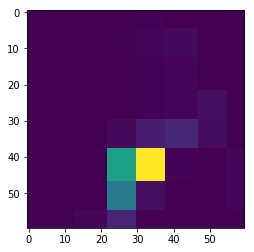

In [121]:
resized = scipy.ndimage.zoom(predicted_proba, (1,IMAGE_SIZE_NEW[0]/predicted_proba.shape[1],
                                               IMAGE_SIZE_NEW[1]/predicted_proba.shape[2], 1), order=0)

#print(predicted_proba)
#print(resized.shape[2])
num_1 = resized.shape[1]
num_2 = resized.shape[2]
new_matrix = [[0 for x in range(num_2)] for y in range(num_1)]
m = 0
for i in range(0, num_1):
    for j in range(0, num_2):
        #original_matrix[i][j] = i1
        prob = round(resized[0][i][j][ll]*100, 1)
        new_matrix[i][j] = prob
#        if prob > min_prob:
#            original_matrix[i][j] 
#        else:
#            original_matrix[i][j] = -255
#print(original_matrix)
new_matrix = np.array(new_matrix)
#original_matrix = np.ma.masked_where(original_matrix < 0, original_matrix)
plt.imshow(new_matrix)
#print(new_matrix)

In [122]:
#from collections import Counter
#count = Counter(original_matrix)
#Counter({'a': 2, 'c': 2, 'b': 1, 'd': 1})
#count.most_common()
#print(original_matrix)

In [123]:
#new_matrix = np.array(new_matrix)
#new_matrix = (new_matrix/255)
#print(new_matrix[40])

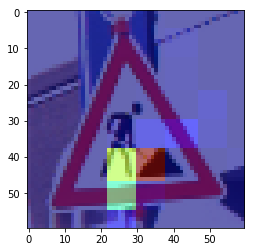

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Generate some data...
#gray_data = np.arange(10000).reshape(100, 100)

#masked_data = np.random.random(IMAGE_SIZE_NEW)

masked_data = np.ma.masked_where(new_matrix < 0, new_matrix)
#masked_data = np.dot(masked_data, 10)
# Overlay the two images
fig, ax = plt.subplots()
ax.imshow(img_original, cmap=cm.gray)
ax.imshow(masked_data, cmap=cm.jet, alpha=0.6)
plt.show()